In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import time
import datetime
from typing import Dict, Tuple

# Load raw data

In [2]:
data_raw_filename = "data_raw_fake.csv"

In [3]:
dataset = pd.read_csv(data_raw_filename)

In [4]:
dataset.head().T

,0,1,2,3,4
date,2020-03-27 12:52:08,2020-03-27 14:36:29,2020-03-28 08:47:35,2020-03-28 09:38:40,2020-03-30 17:58:36
restaurant,/be/api/restaurants/181,NaN,/be/api/restaurants/181,NaN,/be/api/restaurants/244
status,-1,-1,-1,-1,-1
total_cost,21.5,0,20.5,0,25.1
rest,&{Long:27.577507 Lat:53.930103},NaN,&{Long:27.577507 Lat:53.930103},NaN,&{Long:27.652157 Lat:53.933624}
dest,&{Long:27.599731 Lat:53.925205},NaN,&{Long:27.599731 Lat:53.925205},NaN,&{Long:27.599731 Lat:53.925205}
courier,NaN,NaN,NaN,NaN,NaN


In [5]:
dataset.dtypes

date           object
restaurant     object
status          int64
total_cost    float64
rest           object
dest           object
courier       float64
dtype: object

In [6]:
dataset.describe()

,status,total_cost,courier
count,502.0,502.000000,0.0
mean,-1.0,13.680558,NaN
std,0.0,14.573024,NaN
min,-1.0,0.000000,NaN
25%,-1.0,0.000000,NaN
50%,-1.0,9.000000,NaN
75%,-1.0,25.975000,NaN
max,-1.0,67.400002,NaN


# Prepare data

## List categorical columns

In [7]:
categorical_columns = ['restaurant']

In [8]:
def split_column(df: pd.DataFrame, name: str):
    df[name+'_long'] = df[name].str.extract("&{Long:(\d+\.\d+)", expand=False).astype('float64')
    df[name+'_lat'] = df[name].str.extract("Lat:(\d+\.\d+)}", expand=False).astype('float64')
    return df.drop([name], axis=1)

In [9]:
def replace_coordinates(df: pd.DataFrame):
    df = split_column(df, "rest")
    df = split_column(df, "dest")
    #df = split_column(df, "courier")
    return df

In [10]:
dataset = replace_coordinates(dataset)

## Geodata

In [11]:
def plot_geodata(dataset: pd.DataFrame): 
    gdf = geopandas.GeoDataFrame(dataset.copy(), 
                                 geometry=geopandas.points_from_xy(dataset.rest_long, dataset.rest_lat))
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    ax = world[world.continent == 'Europe'].plot(color='white', edgecolor='black')

    gdf.plot(ax=ax, color='red',  figsize=(256, 256))

    plt.show()

In [12]:
#plot_geodata(dataset)

##  Handle N/A values

In [13]:
dataset.isna().sum()

date            0
restaurant    251
status          0
total_cost      0
courier       502
rest_long     251
rest_lat      251
dest_long     251
dest_lat      251
dtype: int64

### Replace other NaN with explicit 'n/a' value

In [14]:
def replace_na_value(dataset: pd.DataFrame):
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
        
        dataset[column] = dataset[column].fillna('n/a')

In [15]:
replace_na_value(dataset)

## Convert columns types
Easier to work with later, handle as generic category

In [16]:
def convert_column_type(dataset, column_name, result_type):
    dataset[column_name] = dataset[column_name].astype(result_type)

In [17]:
convert_column_type(dataset, 'date', 'datetime64')
convert_column_type(dataset, 'restaurant', str)
convert_column_type(dataset, 'status', str)

## State machine - convert events to orders

In [18]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) * 1000

In [19]:
data = []

start_date = None
curr_restaurant = None
curr_total_cost = None
curr_distance = None

rest_lat = None
rest_long = None
dest_lat = None
dest_long = None

for index, row in dataset.iterrows():
    restaurant = str(row['restaurant'])
    if 'n/a' in restaurant:
        if curr_restaurant is not None:
            distance = haversine(rest_lat, rest_long, dest_lat, dest_long)
            total_time_sec = (row['date']-start_date).total_seconds()
            data.append([start_date, curr_restaurant, curr_total_cost, distance, total_time_sec])
            
            curr_restaurant = None
    else:
        if curr_restaurant is None:
            curr_restaurant = restaurant
            start_date = row['date']
            curr_total_cost = row['total_cost']
            
            rest_lat = row['rest_lat']
            rest_long = row['rest_long']
            dest_lat = row['dest_lat']
            dest_long = row['dest_long']
        

df = pd.DataFrame(data, columns=['date', 'restaurant', 'total_cost', 'distance_meters', 'total_time_sec'])

In [20]:
df.dtypes

date               datetime64[ns]
restaurant                 object
total_cost                float64
distance_meters           float64
total_time_sec            float64
dtype: object

In [21]:
df.head().T

,0,1,2,3,4
date,2020-03-27 12:52:08,2020-03-28 08:47:35,2020-03-30 17:58:36,2020-04-02 12:19:02,2020-04-03 08:31:33
restaurant,/be/api/restaurants/181,/be/api/restaurants/181,/be/api/restaurants/244,/be/api/restaurants/181,/be/api/restaurants/181
total_cost,21.5,20.5,25.1,22.3,20.2
distance_meters,1553.64,1553.64,3557.68,1553.64,1553.64
total_time_sec,6261,3065,3453,2028,3359


# ===========
# Work with processed data

## Handle date columns

### Extract date fields

In [22]:
def extract_date_fields(dataset: pd.DataFrame, field_name: str):
    df[field_name+'_year'] = df[field_name].dt.year
    df[field_name+'_month'] = df[field_name].dt.month
    df[field_name+'_day'] = df[field_name].dt.day
    df[field_name+'_day_of_week'] = df[field_name].dt.dayofweek
    df[field_name+'_hour'] = df[field_name].dt.hour
    df[field_name+'_minute'] = df[field_name].dt.minute
    
    return df.drop([field_name], axis=1)

In [23]:
df = extract_date_fields(df, 'date')

## Encode categorical columns

In [24]:
def encode_categorical_columns(dataset: pd.DataFrame, columns) -> Dict[str, LabelEncoder]:
    encoders = {} 
    for column in columns:
        if column not in dataset.columns:
            continue
            
        le = LabelEncoder()
        le.fit(dataset[column])

        dataset[column] = le.transform(dataset[column])
        encoders[column]= le
        
    return encoders

In [25]:
categorical_columns += ['date_year', 'date_month', 'date_day', 'date_day_of_week', 'date_hour', 'date_minute']
encoders = encode_categorical_columns(df, categorical_columns)

## Convert to epoch time

In [26]:
date_columns = ['date']

In [27]:
def convert_date_columns_to_epoch(dataset: pd.DataFrame, timestamp_format="%Y-%m-%d %H:%M:%S"):
    for column in date_columns:
        dataset[column] = (dataset[column] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [28]:
#convert_date_columns_to_epoch(df)

In [29]:
df.dtypes

restaurant            int64
total_cost          float64
distance_meters     float64
total_time_sec      float64
date_year             int64
date_month            int64
date_day              int64
date_day_of_week      int64
date_hour             int64
date_minute           int64
dtype: object

In [30]:
df.head().T

,0,1,2,3,4
restaurant,2.000000,2.000000,6.000000,2.000000,2.000000
total_cost,21.500000,20.500000,25.100000,22.299999,20.200001
distance_meters,1553.644833,1553.644833,3557.680665,1553.644833,1553.644833
total_time_sec,6261.000000,3065.000000,3453.000000,2028.000000,3359.000000
date_year,0.000000,0.000000,0.000000,0.000000,0.000000
date_month,0.000000,0.000000,0.000000,1.000000,1.000000
date_day,26.000000,27.000000,29.000000,1.000000,2.000000
date_day_of_week,4.000000,5.000000,0.000000,3.000000,4.000000
date_hour,4.000000,0.000000,9.000000,4.000000,0.000000
date_minute,52.000000,47.000000,58.000000,19.000000,31.000000


## Scale/normalize all columns

In [31]:
def scale_columns(dataset: pd.DataFrame, columns):
    scaler = StandardScaler()
    dataset[columns] = scaler.fit_transform(dataset[columns])

In [32]:
scale_columns(df, ['total_cost', 'distance_meters'])

## Reorder columns

In [33]:
def reorder_columns(dataset):
    top_columns = ['total_time_sec']
    return dataset[[c for c in df if c not in top_columns] 
       + top_columns]

In [34]:
df = reorder_columns(df)

In [35]:
df.dtypes

restaurant            int64
total_cost          float64
distance_meters     float64
date_year             int64
date_month            int64
date_day              int64
date_day_of_week      int64
date_hour             int64
date_minute           int64
total_time_sec      float64
dtype: object

In [36]:
df.head().T

,0,1,2,3,4
restaurant,2.000000,2.000000,6.000000,2.000000,2.000000
total_cost,-0.832352,-0.974364,-0.321107,-0.718742,-1.016968
distance_meters,-1.039000,-1.039000,0.243791,-1.039000,-1.039000
date_year,0.000000,0.000000,0.000000,0.000000,0.000000
date_month,0.000000,0.000000,0.000000,1.000000,1.000000
date_day,26.000000,27.000000,29.000000,1.000000,2.000000
date_day_of_week,4.000000,5.000000,0.000000,3.000000,4.000000
date_hour,4.000000,0.000000,9.000000,4.000000,0.000000
date_minute,52.000000,47.000000,58.000000,19.000000,31.000000
total_time_sec,6261.000000,3065.000000,3453.000000,2028.000000,3359.000000


In [37]:
def prepare_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    encode_categorical_columns(dataset)
    dataset = extract_date_fields(dataset, 'date')
    #convert_date_columns_to_epoch(dataset)

    scale_columns(dataset)
    dataset = reorder_columns(dataset)
    
    return dataset

# =======
# Check regression models

# Split dataset

In [38]:
def split_dataset(dataset: pd.DataFrame): 
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]

    return train_test_split(X, y, test_size=0.2, random_state = 0)

In [39]:
X_train, X_test, y_train, y_test = split_dataset(df)

# Train models

In [40]:
models_result = {}

In [41]:
def update_result_print(models_result, model_name, regr, X_test, y_test):
    from sklearn.metrics import r2_score
    
    y_pred = regr.predict(X_test)
    y_test = y_test.values.tolist()
    
    print("y_pred:")
    print(y_pred)
    print("y_test:")
    print(y_test)

    accuracy = r2_score(y_test, y_pred)

    models_result[model_name] = accuracy
    print(f'"{model_name}" has r2_score: {accuracy}') 
    return accuracy

In [42]:
def plot_features_importances(regressor, X_train):
    series = pd.Series(regressor.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    series = series.plot(kind='barh', figsize=(10,10))
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.show()

## Random forest

In [43]:
def random_forest(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(max_depth=2, n_estimators = 20, random_state = 0)

    regr.fit(X_train, y_train)
    
    return regr

y_pred:
[ 5025.93969671  3558.29936921  4134.80456178  4482.27614384
  4633.98728951  4696.98147556  4482.27614384  4358.50674707
  4137.04102131  4696.98147556  3498.19706988  4757.74113567
  3887.28968053  4419.28195779  3495.14001576  3581.53422312
  4028.50658705  3495.14001576  4482.27614384  3999.58671397
  3495.14001576  3434.36480503  4060.3619247   4820.73532171
  4696.98147556  4134.80456178  3999.58671397  4127.28894127
  4633.98728951 19131.94659889  5052.71825695  4421.50093311
  4195.57977251  4195.57977251  4664.21490495  4833.94410853
  4482.27614384  3532.03809309  4573.21207879  4757.74113567
  4195.57977251  3903.21525825  4229.89365548  4195.57977251
  4038.43310605  3486.44512942  3495.14001576  3903.21525825
  4421.50093311  4696.98147556  4133.52219976]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094

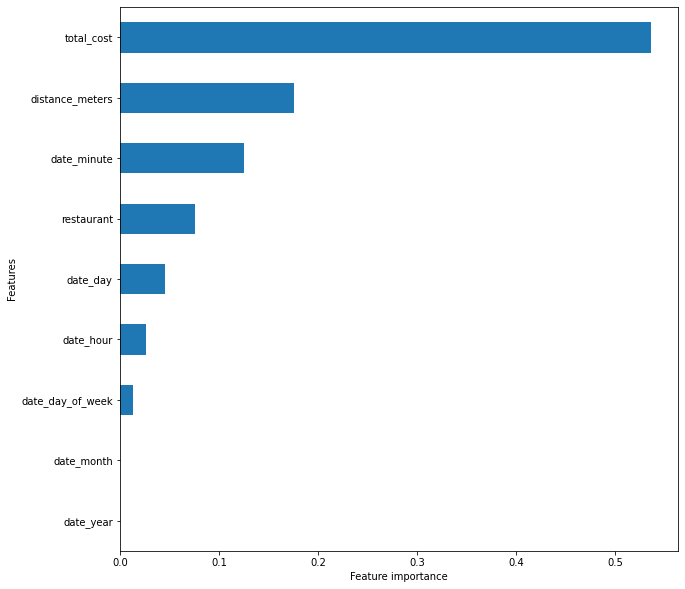

In [44]:
rf_rgr = random_forest(X_train, y_train)
update_result_print(models_result, 'Random forest', rf_rgr, X_test, y_test)
plot_features_importances(rf_rgr, X_train)

## K-Nearest Neighbors

In [45]:
def k_nearest(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    regr = KNeighborsRegressor(n_neighbors=8)
    
    regr.fit(X_train, y_train)
    
    return regr

In [46]:
k_nearest_regr = k_nearest(X_train, y_train)
update_result_print(models_result, 'K-Nearest Neighbors', k_nearest_regr, X_test, y_test)
#plot_features_importances(k_nearest_regr, X_train)

y_pred:
[ 4798.125  6223.375  3997.5    6526.625  3834.375  7023.25   5558.5
  5286.     4776.     4462.875  7479.5    5021.625  3669.5    4844.5
  4853.375  4051.     3273.     3225.25   4708.375  2692.375  3263.75
  3505.875  2823.125  4126.125  3338.875  3273.    15906.125  4178.5
  3861.5    4588.625  5558.5    5244.125  4096.375  4868.75   4984.25
  5639.125  4045.125  4553.875  4123.5    3773.     7448.25   5230.375
  4006.     4005.375  3868.     3444.125  3447.875  4528.375  5050.625
  3206.875  4582.5  ]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2868.0, 6280.0, 4562.0, 6794.0, 4480.0, 4664.0, 3663.0, 3157.0, 4643.0, 1495.0, 4336.0, 3077.0, 3853.0, 2280.0, 2977.0, 2315.0, 6921.0, 5380.0, 3954.0]
"K-Nearest Neighbors" has r2_score: -1.7215697120882614


-1.7215697120882614

## Decision tree

In [47]:
def decision_tree(X_train, y_train):
    from sklearn.tree import DecisionTreeRegressor
    regr = DecisionTreeRegressor(max_depth=4)
    
    regr.fit(X_train, y_train)
    
    return regr

In [48]:
decision_tree_regr = decision_tree(X_train, y_train)
update_result_print(models_result, 'Decision tree', decision_tree_regr, X_test, y_test)
#plot_features_importances(decision_tree_regr, X_train)

y_pred:
[5752.15384615 4177.36363636 4177.36363636 4257.66666667 4257.66666667
 4257.66666667 4257.66666667 4257.66666667 6132.         4257.66666667
 4177.36363636 5752.15384615 4417.05555556 4257.66666667 2993.14893617
 4417.05555556 2993.14893617 2993.14893617 4257.66666667 2993.14893617
 2993.14893617 2993.14893617 2993.14893617 5752.15384615 4257.66666667
 4177.36363636 2993.14893617 4177.36363636 4257.66666667 4417.05555556
 4257.66666667 4257.66666667 4177.36363636 4177.36363636 4257.66666667
 5752.15384615 4257.66666667 3192.73333333 4257.66666667 5752.15384615
 4177.36363636 2993.14893617 4177.36363636 4177.36363636 4177.36363636
 2993.14893617 2993.14893617 2993.14893617 4257.66666667 4257.66666667
 4177.36363636]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2

0.12162581470397082

## Linear regression

In [49]:
def linear(X_train, y_train):
    from sklearn.linear_model import LinearRegression
    regr = LinearRegression()
    
    regr.fit(X_train, y_train)
    
    return regr

In [50]:
linear_regr = linear(X_train, y_train)
update_result_print(models_result, 'Linear', linear_regr, X_test, y_test)
#plot_features_importances(linear_regr, X_train)

y_pred:
[3148.25245628 4078.57335895 3491.01203397 4990.02897593 5501.80670868
 3917.36911183 6399.4591701  5970.66277203 4090.18227003 3199.64689094
 3797.01828448 5727.06383544 4816.93804061 3951.88595801 5148.39987821
 2800.86101481 3556.83208427 6193.78245561 3178.62161138 4433.56593629
 6258.96331875 6443.05863938 4790.59729864 3905.59280005 3535.6763181
 2864.32822809 5930.62217075 4265.18661875 6089.57425158 7194.46571209
 6329.66566924 3653.16307694 4407.33446268 3710.36527903 4908.74745211
 5603.98071832 5282.58100479 6256.37071396 6463.95258256 3346.68763267
 3602.60619569 6788.61631875 4426.59563434 3276.42739498 5894.53172113
 3531.20866985 6220.19925873 7432.89120438 3833.77071246 3769.46261483
 3175.61642876]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 28

-1.0306889148843412

## Ridge regression

In [51]:
def ridge(X_train, y_train):
    from sklearn.linear_model import Ridge
    regr = Ridge(alpha=.5)
    
    regr.fit(X_train, y_train)
    
    return regr

In [52]:
ridge_regr = ridge(X_train, y_train)
update_result_print(models_result, 'Ridge', ridge_regr, X_test, y_test)
#plot_features_importances(ridge_regr, X_train)

y_pred:
[3148.85327084 4079.1510543  3490.71777278 4989.66625652 5501.73196809
 3917.15505201 6399.34744784 5970.51176921 4090.16653916 3197.14484689
 3798.13661652 5727.36107909 4816.87957984 3952.25007022 5148.52223663
 2802.0419935  3557.28094173 6193.86891934 3178.84560052 4433.73755374
 6258.98230261 6442.80560368 4790.64231068 3906.1898102  3535.51055725
 2864.65412192 5930.21162442 4265.48371698 6089.41996353 7193.92298786
 6329.74053821 3653.28313374 4407.42877323 3711.00718568 4908.54803006
 5603.27890365 5282.20042997 6255.48082082 6463.10150558 3347.02221146
 3602.82971219 6787.95400751 4426.84738041 3276.68600405 5894.38064098
 3532.47813814 6220.36544175 7432.09216764 3833.70416966 3769.18148182
 3175.92394646]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2

-1.0305678265727551

## Multi-layer perceptron
TODO requires OneHotEncoder

In [53]:
def mlp(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    regr = MLPRegressor(solver='adam', alpha=1e-5,
                        hidden_layer_sizes=(X_train.columns.size, X_train.columns.size+10), 
                        max_iter=1000, activation='relu',
                        learning_rate_init=.01,
                        random_state=0)
    
    regr.fit(X_train, y_train)
    
    return regr

In [54]:
mlp_regr = mlp(X_train, y_train)
update_result_print(models_result, 'Multi-layer perceptron', mlp_regr, X_test, y_test)
#plot_features_importances(mlp_regr, X_train)

y_pred:
[1645.05008833 5075.27089743 4541.22107221 5422.33809963 5766.9643315
 5467.03752892 5959.78557269 6038.17210077 4867.60896613 5149.06784944
 5383.73496947 5124.61102512 5447.08107616 8405.77857272 1097.15033484
 6855.0986518  3974.48228515 2724.07020532 6124.7001712  5652.99912057
 2464.76405691 2221.40361401 2942.78855869 3568.53659883 4572.27334854
 4549.30443741 4751.34210333 6297.52996867 7001.98012995 4791.54854584
 5923.24732731 5171.08855797 5460.62778962 4659.35030491 7013.20657966
 3888.35242592 4602.69037265  817.30828534 5801.50677952 2925.00700708
 5359.9178002  5680.83518214 7862.82156124 4330.89528981 6897.14933759
 7172.06977139 2422.51143116 4506.8691675  4058.48610786 3282.45701044
 5495.21103306]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 28

-1.328611116738092

## Support Vector Machine

In [55]:
def svm(X_train, y_train):
    from sklearn.svm import SVR 
    regr = SVR(kernel='poly', degree=2)
    
    regr.fit(X_train, y_train)
    
    return regr

In [56]:
svm_regr = svm(X_train, y_train)
update_result_print(models_result, 'Support Vector Machine', svm_regr, X_test, y_test)
#plot_features_importances(svm_regr, X_train)

y_pred:
[3649.35964926 3651.82050808 3650.13640995 3651.46087533 3653.6757721
 3650.47149669 3657.62867172 3660.25543765 3656.24194725 3653.14800751
 3650.26561673 3658.83583778 3658.80477941 3669.26461128 3649.46501233
 3661.5258953  3650.19422224 3653.9160419  3654.49034563 3659.16917348
 3652.61285542 3651.49140584 3651.54859889 3651.00309852 3649.0127229
 3650.235603   3659.75467265 3656.19318918 3667.24658965 3669.08883094
 3657.64641723 3648.22503434 3649.04177829 3649.15818142 3658.07515092
 3658.31384711 3654.83934488 3649.55729701 3656.32247159 3651.16674756
 3649.98597223 3664.56400724 3669.4794922  3651.0790777  3659.64726552
 3661.28386653 3652.17698738 3654.68046705 3653.59376708 3651.5958396
 3653.96024876]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2868

-0.034493317959015224

## ElasticNet

In [57]:
def elastic(X_train, y_train):
    from sklearn.linear_model import ElasticNetCV
    regr = ElasticNetCV()
    
    regr.fit(X_train, y_train)
    
    return regr

In [58]:
elastic_regr = elastic(X_train, y_train)
update_result_print(models_result, 'ElasticNet', elastic_regr, X_test, y_test)
#plot_features_importances(elastic_regr, X_train)

y_pred:
[4520.20946913 4499.449286   4298.17701036 4572.18310474 4922.22743419
 4444.58852541 5015.08102134 5037.11831527 4664.7494597  4306.0094038
 4594.03397354 5075.06956896 4542.85065788 4767.63029188 4527.88962373
 4654.83266367 4356.25060205 4749.73803863 4465.08362151 4770.62871142
 4756.62326496 4784.55081534 4603.31446243 4767.49729831 4312.70727667
 4389.69751342 4998.00734148 4734.16506944 4987.81203028 5010.2228179
 5008.00020342 4529.53671197 4596.59306017 4528.41733996 4661.03251854
 4710.54689949 4669.12471909 4559.70895813 4945.48863995 4528.82359517
 4487.70800446 5031.48853346 4831.37341242 4316.18471002 4828.59627365
 4807.59701211 4760.09430571 5004.94395656 4546.76256093 4420.01041616
 4394.37422741]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 286

-0.24771389519097542

# Results

In [59]:
for k,v in sorted(models_result.items(), key=lambda entry:entry[1], reverse=True):
    print(f'{k:25s} {v}')

Decision tree             0.12162581470397082
Support Vector Machine    -0.034493317959015224
ElasticNet                -0.24771389519097542
Ridge                     -1.0305678265727551
Linear                    -1.0306889148843412
Multi-layer perceptron    -1.328611116738092
K-Nearest Neighbors       -1.7215697120882614
Random forest             -1.7879132998875864
